# Fluxing with PYPIT [v1.1]

In [1]:
%matplotlib inline

In [2]:
# import
from importlib import reload
import os
from matplotlib import pyplot as plt
import glob
import numpy as np

from astropy.table import Table

from pypit import fluxspec

## Running the script 

### Generate the sensitivity function from an extracted standard star

#### Output is in sensfunc_file

    pypit_flux_spec sensfunc --std_file=spec1d_Feige66_KASTb_2015May20T041246.96.fits  --instr=shane_kast_blue --sensfunc_file=tmp.yaml

### Apply it to all spectra a spec1d science file

#### Output is in flux_file

    pypit_flux_spec flux --sci_file=spec1d_J1217p3905_KASTb_2015May20T045733.56.fits --sensfunc_file=tmp.yaml --flux_file=tmp.fits

### You can do it in one go if you really want..

    pypit_flux_spec sensfunc,flux --std_file=spec1d_Feige66_KASTb_2015May20T041246.96.fits --sci_file=spec1d_J1217p3905_KASTb_2015May20T045733.56.fits --sensfunc_file=tmp.yaml --flux_file=tmp.fits

### Multi-detector (DEIMOS)
    pypit_flux_spec sensfunc --std_file=spec1d_G191B2B_DEIMOS_2017Sep14T152432.fits  --instr=keck_deimos --sensfunc_file=sens.yaml --multi_det=3,7

----

## To play along from here, you need the Development suite *reduced* 

### And the $PYPIT_DEV environmental variable pointed at it

In [3]:
os.getenv('PYPIT_DEV')

'/data/Projects/Python/PYPIT-development-suite/'

## Instantiate from spec1d file

In [4]:
std_file = os.getenv('PYPIT_DEV')+'Cooked/Science/spec1d_Feige66_KASTb_2015May20T041246.96.fits'
sci_file = os.getenv('PYPIT_DEV')+'Cooked/Science/spec1d_J1217p3905_KASTb_2015May20T045733.56.fits'

In [5]:
# nit
reload(fluxspec)
FxSpec = fluxspec.FluxSpec(std_spec1d_file=std_file, spectrograph='shane_kast_blue', sci_spec1d_file=sci_file, setup='A_01_aa')

[INFO]    :: arparse.py 75 load_file() - Loading default settings
[INFO]    :: arparse.py 87 load_file() - Loading base settings from settings.baseargflag
[INFO]    :: arparse.py 1393 run_ncpus() - Setting 19 CPUs
[INFO]    :: arparse.py 75 load_file() - Loading default settings
[INFO]    :: arparse.py 75 load_file() - Loading default settings
[INFO]    :: arparse.py 87 load_file() - Loading base settings from settings.basespect
[INFO]    :: arparse.py 75 load_file() - Loading default settings
[INFO]    :: arparse.py 75 load_file() - Loading default settings
[INFO]    :: arparse.py 87 load_file() - Loading base settings from settings.basespect
[INFO]    :: arparse.py 75 load_file() - Loading default settings
[INFO]    :: fluxspec.py 100 __init__() - Loaded 1 spectra from the spec1d standard star file: /data/Projects/Python/PYPIT-development-suite/REDUX_OUT/Shane_Kast_blue/600_4310_d55/shane_kast_blue_setup_A/Science/spec1d_Feige66_KASTb_2015May20T041246.96.fits
[INFO]    :: fluxspec.py

## Find the standard (from the brightest spectrum)

In [6]:
std = FxSpec.find_standard()
std

[INFO]    :: arflux.py 435 find_standard() - Putative standard star has a median boxcar count of 16657.892060782513


<SpecObjExp: O479-S5009-D01-I0023 == Setup dum_config Object at 0.479 in Slit at 0.5009 with det=01, scidx=23 and objtype=unknown>

## Sensitivity Function

In [7]:
sensfunc = FxSpec.generate_sensfunc()
sensfunc

[INFO]    :: arflux.py 370 load_extinction_data() - Using mthamextinct.dat for extinction corrections.
[INFO]    :: arflux.py 300 find_standard_file() - Using standard star FEIGE66
[INFO]    :: arflux.py 406 load_standard_file() - Loading standard star file: /data/Projects/Python/PYPIT/pypit/data/standards/calspec/feige66_002.fits.gz
[INFO]    :: arflux.py 407 load_standard_file() - Fluxes are flambda, normalized to 1e-17
[INFO]    :: arflux.py 500 generate_sensfunc() - Masking edges
[WARNING] :: arflux.py 506 generate_sensfunc() - Should pull resolution from arc line analysis
[INFO]    :: arflux.py 510 generate_sensfunc() - Masking Balmer
[INFO]    :: arflux.py 518 generate_sensfunc() - Masking Telluric
[INFO]    :: arflux.py 525 generate_sensfunc() - Masking Below the atmospheric cutoff
[INFO]    :: arflux.py 203 bspline_magfit() - Difference between fits is 0.000212286
[WORK IN ]::
[PROGRESS]:: arflux.py 206 bspline_magfit() - Add QA for sensitivity function


{'c': [array([3436.35157382, 3436.35157382, 3436.35157382, 3436.35157382,
         3477.70046133, 3519.04934884, 3560.39823635, 3601.74712386,
         3643.09601137, 3684.44489888, 3725.79378639, 3767.1426739 ,
         3808.49156141, 3849.84044892, 3891.18933643, 3932.53822394,
         3973.88711145, 4015.23599896, 4056.58488647, 4097.93377398,
         4139.28266149, 4180.631549  , 4221.98043651, 4263.32932402,
         4304.67821153, 4346.02709904, 4387.37598655, 4428.72487406,
         4470.07376157, 4511.42264908, 4552.77153659, 4594.1204241 ,
         4635.46931161, 4676.81819912, 4718.16708663, 4759.51597414,
         4800.86486165, 4842.21374916, 4883.56263667, 4924.91152418,
         4966.26041169, 5007.6092992 , 5048.95818671, 5090.30707422,
         5131.65596173, 5173.00484924, 5214.35373675, 5255.70262426,
         5297.05151177, 5338.40039928, 5379.74928679, 5421.0981743 ,
         5462.44706181, 5503.79594932, 5503.79594932, 5503.79594932,
         5503.79594932]),
  a

### Plot

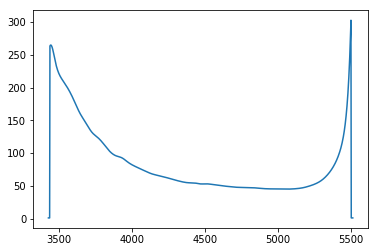

In [8]:
FxSpec.show_sensfunc()

In [9]:
FxSpec.steps

['find_standard', 'generate_sensfunc']

## Flux science

In [10]:
FxSpec.flux_science()

[INFO]    :: arflux.py 370 load_extinction_data() - Using mthamextinct.dat for extinction corrections.
[INFO]    :: arflux.py 46 new_apply_sensfunc() - Fluxing boxcar extraction for:
             <SpecObjExp: O500-S5009-D01-I0024 == Setup dum_config Object at 0.5 in Slit at 0.5009 with det=01, scidx=24 and objtype=unknown>
[INFO]    :: arflux.py 46 new_apply_sensfunc() - Fluxing optimal extraction for:
             <SpecObjExp: O500-S5009-D01-I0024 == Setup dum_config Object at 0.5 in Slit at 0.5009 with det=01, scidx=24 and objtype=unknown>


In [11]:
FxSpec.sci_specobjs[0].optimal

{'counts': array([10.93385074, 23.9450477 , 22.67900159, ..., 45.69617815,
        36.15994806, 49.86455587]),
 'flam': array([0.01770588, 0.03874828, 0.03667356, ..., 0.04488977, 0.03552047,
        0.04898085]),
 'flam_var': array([0.00035894, 0.00042918, 0.00038679, ..., 0.00015337, 0.00014429,
        0.00015296]),
 'var': array([136.87781873, 163.89421183, 147.91783914, ..., 158.93377013,
        149.53380374, 158.53226772]),
 'wave': <Quantity [3427.54208984, 3428.4360771 , 3429.33021426, ..., 5512.79931848,
            5513.90316648, 5515.00705956] Angstrom>}

### Plot

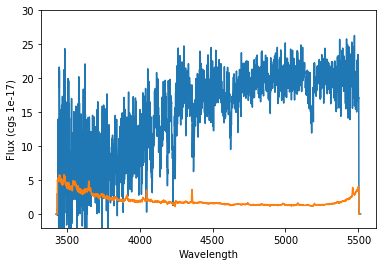

In [12]:
plt.clf()
ax = plt.gca()
ax.plot(FxSpec.sci_specobjs[0].optimal['wave'], FxSpec.sci_specobjs[0].optimal['flam'])
ax.plot(FxSpec.sci_specobjs[0].optimal['wave'], np.sqrt(FxSpec.sci_specobjs[0].optimal['flam_var']))
ax.set_ylim(-2, 30.)
# 
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux (cgs 1e-17)')
plt.show()

### Write

In [13]:
FxSpec.write_science('tmp.fits')

[INFO]    :: arsave.py 459 new_save_1d_spectra_fits() - Wrote 1D spectra to tmp.fits


In [14]:
FxSpec.steps

['find_standard', 'generate_sensfunc', 'flux_science', 'write_science']

## MasterFrames

In [15]:
FxSpec.setup = 'A_01_aa'

In [16]:
FxSpec.settings['masters']

{'directory': 'MF_shane_kast_blue',
 'force': False,
 'loaded': [],
 'reuse': False}

### Save

In [17]:
os.mkdir('MF_shane_kast_blue')
FxSpec.save_master()

[INFO]    :: fluxspec.py 195 save_master() - Wrote sensfunc to MasterFrame: MF_shane_kast_blue/MasterSensFunc_A_aa.yaml


### Load

In [18]:
sensfunc2, _, _ = FxSpec.load_master_frame(force=True)
sensfunc2.keys()

dict_keys(['c', 'func', 'max', 'min', 'std', 'steps', 'wave_max', 'wave_min'])

## Instantiate from a sensitivity function

In [19]:
reload(fluxspec)
FxSpec3 = fluxspec.FluxSpec(sci_spec1d_file=sci_file, sens_file='MF_shane_kast_blue/MasterSensFunc_A_aa.yaml')

[INFO]    :: fluxspec.py 103 __init__() - Loaded spectra from the spec1d science file: /data/Projects/Python/PYPIT-development-suite/REDUX_OUT/Shane_Kast_blue/600_4310_d55/shane_kast_blue_setup_A/Science/spec1d_J1217p3905_KASTb_2015May20T045733.56.fits
[WARNING] :: masterframe.py 55 __init__() - MasterFrame class not proper loaded (e.g. no masters in settings).  Avoid using Master methods


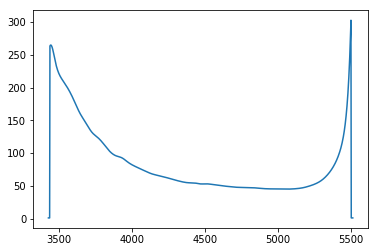

In [20]:
FxSpec3.show_sensfunc()

## Clean up


In [21]:
os.remove(FxSpec.ms_name)
os.rmdir('MF_shane_kast_blue')

----

## Development

In [22]:
reload(fluxspec)
FxSpec = fluxspec.FluxSpec(std_spec1d_file=std_file, spectrograph='shane_kast_blue', sci_spec1d_file=sci_file, setup='A_01_aa')

[INFO]    :: arparse.py 75 load_file() - Loading default settings
[INFO]    :: arparse.py 87 load_file() - Loading base settings from settings.baseargflag
[INFO]    :: arparse.py 1393 run_ncpus() - Setting 19 CPUs
[INFO]    :: arparse.py 75 load_file() - Loading default settings
[INFO]    :: arparse.py 75 load_file() - Loading default settings
[INFO]    :: arparse.py 87 load_file() - Loading base settings from settings.basespect
[INFO]    :: arparse.py 75 load_file() - Loading default settings
[INFO]    :: arparse.py 75 load_file() - Loading default settings
[INFO]    :: arparse.py 87 load_file() - Loading base settings from settings.basespect
[INFO]    :: arparse.py 75 load_file() - Loading default settings
[INFO]    :: fluxspec.py 100 __init__() - Loaded 1 spectra from the spec1d standard star file: /data/Projects/Python/PYPIT-development-suite/REDUX_OUT/Shane_Kast_blue/600_4310_d55/shane_kast_blue_setup_A/Science/spec1d_Feige66_KASTb_2015May20T041246.96.fits
[INFO]    :: fluxspec.py

In [23]:
FxSpec.std_specobjs[0].idx

'O479-S5009-D01-I0023'

In [24]:
FxSpec._set_std_obj('O479-S5009-D01-I0023')

<SpecObjExp: O479-S5009-D01-I0023 == Setup dum_config Object at 0.479 in Slit at 0.5009 with det=01, scidx=23 and objtype=unknown>

In [25]:
FxSpec._set_std_obj(1)

<SpecObjExp: O479-S5009-D01-I0023 == Setup dum_config Object at 0.479 in Slit at 0.5009 with det=01, scidx=23 and objtype=unknown>

In [26]:
FxSpec.std

<SpecObjExp: O479-S5009-D01-I0023 == Setup dum_config Object at 0.479 in Slit at 0.5009 with det=01, scidx=23 and objtype=unknown>

### Todo
    Script
    Deal with standard running across multiple detectors (DEIMOS)